In [1]:
import sklearn as sk
import pandas as pd
import time
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.cross_validation import KFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

C:\Users\Yuyoo\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
oliguria = pd.read_csv('../../data/oliguria.csv')
cohort = pd.read_csv('../../data/cohort.csv')
ce = pd.read_csv('../../data/cohort_chartevents.csv')
le = pd.read_csv('../../data/cohort_labevents.csv')

In [3]:
cohort.head()

,subject_id,hadm_id,icustay_id,gender,age,hospital_expire_flag,intime,outtime,los_icu,starttime,og_starttime,og_label
0,21789,112486,200019,F,82.8831,1,2178/7/8 09:03:12,2178/7/11 10:28:40,3.0594,2178/7/8 23:00:00,2178/7/9 23:00:00,1
1,20147,135441,200039,F,69.2750,0,2121/12/26 03:25:00,2122/1/1 15:23:00,6.4986,2121/12/26 08:00:00,2121/12/27 08:00:00,1
2,94414,170244,200143,F,62.2489,1,2191/4/1 21:45:49,2191/4/28 16:32:23,26.7823,2191/4/2 02:16:00,2191/4/3 02:16:00,1
3,20689,129027,200229,M,53.2364,0,2101/8/28 04:49:00,2101/9/14 17:13:34,17.5171,2101/9/11 13:00:00,2101/9/12 13:00:00,1
4,9593,122283,200302,F,300.0016,0,2102/8/3 14:54:01,2102/8/18 14:01:33,14.9636,2102/8/12 08:00:00,2102/8/13 08:00:00,1


In [4]:
oliguria.head()

,icustay_id,intime,og_starttime,los_og,urineoutput_24hr,urineoutput_h
0,200019,2178/7/8 09:03:12,2178/7/9 23:00:00,38,339.0,22.666667
1,200039,2121/12/26 03:25:00,2121/12/27 08:00:00,29,365.0,30.416667
2,200059,2198/2/10 06:05:00,2198/2/11 02:00:00,20,773.0,16.250000
3,200065,2120/3/22 22:30:45,2120/3/22 23:00:00,0,252.0,15.166667
4,200066,2188/10/6 23:56:53,2188/10/7 09:00:00,9,2050.0,12.500000


In [5]:
ce.head()

,subject_id,hadm_id,icustay_id,og_label,starttime,og_starttime,charttime,heartrate,sysbp,diasbp,meanbp,resprate,tempc,spo2
0,3,145834,211552,0,2101/10/20 19:10:11,NaN,2101/10/20 19:15:00,NaN,217.0,38.0,259.000000,NaN,NaN,74.0
1,3,145834,211552,0,2101/10/20 19:10:11,NaN,2101/10/20 19:30:00,151.0,102.0,64.0,76.666702,NaN,NaN,NaN
2,3,145834,211552,0,2101/10/20 19:10:11,NaN,2101/10/20 19:45:00,135.0,94.0,41.0,58.666698,NaN,NaN,NaN
3,3,145834,211552,0,2101/10/20 19:10:11,NaN,2101/10/20 20:00:00,143.0,80.0,49.0,60.000000,24.0,NaN,NaN
4,3,145834,211552,0,2101/10/20 19:10:11,NaN,2101/10/20 20:15:00,165.0,91.0,63.0,72.333298,5.0,NaN,NaN


In [6]:
le.head()

,subject_id,hadm_id,icustay_id,og_label,starttime,og_starttime,charttime,po2,pco2,arterial_ph,...,amylase,lipase,ck_mb,ntprobnp,thrombin,ptt,pt,inr,fibrinogen,d_dimer
0,3,145834,211552,0,2101/10/20 19:10:11,NaN,2101/10/20 16:40:00,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,30.7,13.5,1.3,NaN,NaN
1,3,145834,211552,0,2101/10/20 19:10:11,NaN,2101/10/20 17:58:00,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,145834,211552,0,2101/10/20 19:10:11,NaN,2101/10/20 19:12:00,20.0,40.0,7.35,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,145834,211552,0,2101/10/20 19:10:11,NaN,2101/10/20 19:14:00,313.0,28.0,7.59,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3,145834,211552,0,2101/10/20 19:10:11,NaN,2101/10/20 19:26:00,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,58.3,15.7,1.7,NaN,NaN


In [7]:
tmp = le.drop(['subject_id','hadm_id','icustay_id','og_label','starttime','og_starttime','charttime'],axis=1)
print(tmp.isnull().sum()/len(tmp))

po2                       0.553878
pco2                      0.553896
arterial_ph               0.529326
lactate                   0.808196
be                        0.864965
bicarbonate               0.987851
sao2                      0.830322
total_co2                 0.553896
hemoglobin                0.751548
serum_rbc                 0.754795
serum_wbc                 0.753316
plt                       0.734130
neutrophils               0.940938
hematocrit                0.674796
urine_ph                  0.948561
urine_specific_gravity    0.950975
urine_rbc                 0.988243
urine_wbc                 0.988684
epithelial_cells          0.996813
urine_protein             0.982238
nitrite                   1.000000
alt                       0.933195
ast                       0.933279
serum_albumin             0.953461
total_protein             0.998153
bilirubin_direct          0.994315
bilirubin_indirect        0.994671
troponin_t                0.955338
alp                 

# 数据预处理
## 将24小时内数据聚合

In [8]:
ce_grouped = ce.drop(['subject_id','hadm_id','icustay_id','og_label','starttime','og_starttime','charttime'], axis=1).groupby(ce['icustay_id'])
le_grouped = le.drop(['subject_id','hadm_id','icustay_id','og_label','starttime','og_starttime','charttime'], axis=1).groupby(le['icustay_id'])

In [9]:
# 对ce中的指标取最大最小值、平均值
ce_max = ce_grouped.max().rename(columns=lambda x: x + '_max').reset_index()
ce_min = ce_grouped.min().rename(columns=lambda x: x + '_min').reset_index()
ce_mean = ce_grouped.mean().rename(columns=lambda x: x + '_mean').reset_index()
# 对le中的指标取最大最小值、平均值
le_max = le_grouped.max().rename(columns=lambda x: x + '_max').reset_index()
le_min = le_grouped.min().rename(columns=lambda x: x + '_min').reset_index()
le_mean = le_grouped.mean().rename(columns=lambda x: x + '_mean').reset_index()

In [10]:
# 连接最大值最小值
feature_ce = pd.merge(ce_max,ce_min,left_index=False,right_index=False)
feature_ce = pd.merge(feature_ce,ce_mean,left_index=False,right_index=False)
feature_le = pd.merge(le_max,le_min,left_index=False,right_index=False)
feature_le = pd.merge(feature_le,le_mean,left_index=False,right_index=False)
feature = pd.merge(feature_ce,feature_le,left_index=False,right_index=False)

In [11]:
# 过滤缺失严重的列
def filter_missing_col(df, rate):
    """
    rate: missing rate
    """
    tmp = pd.DataFrame(df.isnull().apply(lambda x:x.sum()/len(x)), columns=['missing_rate'])
    column = tmp[tmp['missing_rate'].values <= rate].index
    return df[column]

In [12]:
feature_filter = filter_missing_col(feature, 0.8)

In [13]:
cohort.shape

(16964, 12)

In [14]:
feature_filter.shape

(16854, 136)

In [15]:
feature_le.shape

(16944, 160)

In [16]:
feature_ce.shape

(16874, 22)

In [17]:
feature.head()

,icustay_id,heartrate_max,sysbp_max,diasbp_max,meanbp_max,resprate_max,tempc_max,spo2_max,heartrate_min,sysbp_min,...,amylase_mean,lipase_mean,ck_mb_mean,ntprobnp_mean,thrombin_mean,ptt_mean,pt_mean,inr_mean,fibrinogen_mean,d_dimer_mean
0,200003,122.0,141.0,81.0,179.000,39.0,38.999998,98.0,72.0,75.0,...,24.0,15.0,NaN,NaN,NaN,31.433333,18.633333,1.8,NaN,NaN
1,200009,106.0,130.0,84.0,101.000,22.0,38.299999,100.0,88.0,86.0,...,NaN,NaN,NaN,NaN,NaN,35.420000,14.480000,1.3,195.0,NaN
2,200019,69.0,206.0,71.0,108.667,29.0,37.222222,100.0,45.0,133.0,...,NaN,NaN,NaN,NaN,NaN,30.900000,14.000000,1.3,NaN,NaN
3,200025,107.0,125.0,101.0,109.000,30.0,38.700001,100.0,78.0,90.0,...,NaN,NaN,NaN,NaN,NaN,28.800000,13.000000,1.1,NaN,NaN
4,200028,113.0,166.0,63.0,98.000,29.0,37.666667,100.0,66.0,74.0,...,NaN,NaN,4.0,NaN,NaN,31.000000,16.800000,1.5,NaN,NaN


In [18]:
data = pd.merge(feature_filter,cohort[['icustay_id','og_label']],left_index=False,right_index=False)

In [19]:
data.head()

,icustay_id,heartrate_max,sysbp_max,diasbp_max,meanbp_max,resprate_max,tempc_max,spo2_max,heartrate_min,sysbp_min,...,sodium_mean,chloride_mean,amylase_mean,lipase_mean,ck_mb_mean,ptt_mean,pt_mean,inr_mean,fibrinogen_mean,og_label
0,200003,122.0,141.0,81.0,179.000,39.0,38.999998,98.0,72.0,75.0,...,141.666667,105.0,24.0,15.0,NaN,31.433333,18.633333,1.8,NaN,0
1,200009,106.0,130.0,84.0,101.000,22.0,38.299999,100.0,88.0,86.0,...,143.000000,114.0,NaN,NaN,NaN,35.420000,14.480000,1.3,195.0,0
2,200019,69.0,206.0,71.0,108.667,29.0,37.222222,100.0,45.0,133.0,...,140.000000,109.0,NaN,NaN,NaN,30.900000,14.000000,1.3,NaN,1
3,200025,107.0,125.0,101.0,109.000,30.0,38.700001,100.0,78.0,90.0,...,138.000000,109.5,NaN,NaN,NaN,28.800000,13.000000,1.1,NaN,0
4,200028,113.0,166.0,63.0,98.000,29.0,37.666667,100.0,66.0,74.0,...,138.666667,113.0,NaN,NaN,4.0,31.000000,16.800000,1.5,NaN,0


In [20]:
data.rename(columns={'icustay_id':'id', 'og_label':'label'},inplace=True)

In [21]:
positive_percent = (data[data['label']==1]['label'].count()/data['label'].count())*100
positive_count = data[data['label']==1]['label'].count()
total_count = data['label'].count()
print('数据集正样本占总样本的{0:.1f}%\n正样本总数为{1}\n总样本总数为{2}'.format(positive_percent, positive_count, total_count))

数据集正样本占总样本的13.8%
正样本总数为2323
总样本总数为16854


# lightgbm

In [22]:
# 随机划分数据集
X=data.drop(['id','label'],axis=1)
y=data['label']
X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.2, random_state=42)

In [23]:
import datetime
import numpy as np
print('开始训练...')
params = {
    'learning_rate': 0.035,
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'binary_logloss' ,'auc','binary_error'},
    'sub_feature': 1,
    'num_leaves': 60,
    'feature_fraction': 1,
    'min_data': 100,
    'min_hessian': 1,
    'verbose': -1,
}

print('开始CV 5折训练...')
scores = []
t0 = time.time()
# 生成训练集预测数组
train_preds = np.zeros(y_train.shape[0])
n_fold = 5
# 生成测试集预测数组
test_preds = np.zeros((y_test.shape[0], n_fold))
# 将训练集进行K折划分
kf = KFold(len(X_train), n_folds=n_fold, shuffle=True, random_state=520)
for i, (train_index, valid_index) in enumerate(kf):
    print('第{}次训练...'.format(i))
    train_feat1 = X_train.iloc[train_index]
    train_feat2 = X_train.iloc[valid_index]   # 验证集输入
    train_lab1 = y_train.iloc[train_index]
    train_lab2 = y_train.iloc[valid_index]
    lgb_train1 = lgb.Dataset(train_feat1, train_lab1)
    lgb_train2 = lgb.Dataset(train_feat2, train_lab2)
    gbm = lgb.train(params,
                    lgb_train1,
                    num_boost_round=3000,
                    valid_sets=lgb_train2,
                    verbose_eval=100,
                    early_stopping_rounds=100)
    gain = gbm.feature_importance('gain')
    feat_imp = pd.DataFrame({'feature':gbm.feature_name(), 'split':gbm.feature_importance('split'), 'gain':100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    feat_imp.to_csv(r'feature_importance/sub{}_{}.csv'.format(datetime.datetime.now().strftime('%Y%m%d_%H%M%S'),i))
    train_preds[valid_index] += gbm.predict(train_feat2)
    test_preds[:, i] = gbm.predict(X_test)
print('验证集得分：    {}'.format(roc_auc_score(y_train, train_preds)))
print('CV训练用时{}秒'.format(time.time() - t0))

开始训练...
开始CV 5折训练...
第0次训练...
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.265446	valid_0's binary_error: 0.10419	valid_0's auc: 0.891221
[200]	valid_0's binary_logloss: 0.261489	valid_0's binary_error: 0.101965	valid_0's auc: 0.891331
Early stopping, best iteration is:
[129]	valid_0's binary_logloss: 0.259809	valid_0's binary_error: 0.103819	valid_0's auc: 0.894049
第1次训练...
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.262749	valid_0's binary_error: 0.0986281	valid_0's auc: 0.864896
[200]	valid_0's binary_logloss: 0.256832	valid_0's binary_error: 0.0949203	valid_0's auc: 0.872776
Early stopping, best iteration is:
[148]	valid_0's binary_logloss: 0.255282	valid_0's binary_error: 0.0960326	valid_0's auc: 0.872178
第2次训练...
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.267126	valid_0's binary_error: 0.10419	valid_0's auc: 0.877933
[200]	

In [24]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
fpr,tpr,th = roc_curve(y_test, test_preds.mean(axis=1))
print('测试集得分： {}'.format(roc_auc_score(y_test, test_preds.mean(axis=1))))

测试集得分： 0.8923472115372079


# 测试集ROC

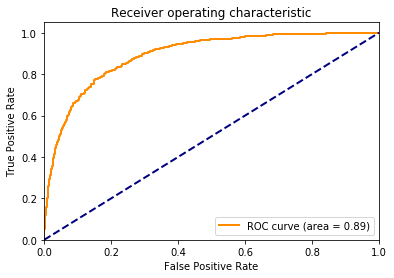

In [30]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_score(y_test, test_preds.mean(axis=1)))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('roc.png')
plt.show()

In [26]:
gain = gbm.feature_importance('gain')
pd.DataFrame({'feature':gbm.feature_name(), 'split':gbm.feature_importance('split'), 'gain':100 * gain / gain.sum()}).sort_values('split', ascending=False)

,feature,gain,split
18,resprate_mean,2.652398,308
93,ptt_min,7.237433,276
21,po2_max,7.356679,260
12,tempc_min,1.510393,243
31,plt_max,1.772926,218
86,magnesium_min,2.948385,217
33,hematocrit_max,1.652845,212
20,spo2_mean,0.890764,204
5,tempc_max,0.968985,197
68,serum_wbc_min,1.256809,187


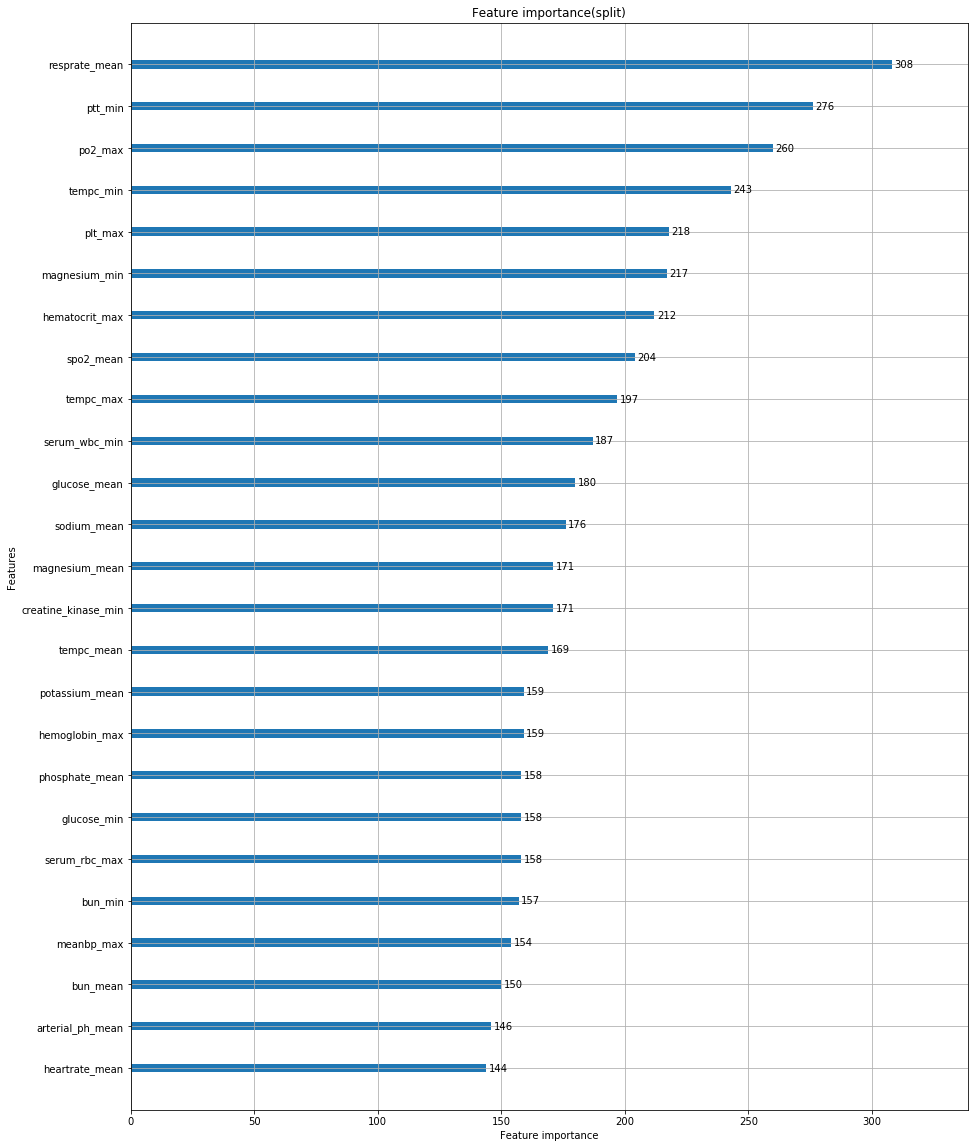

In [27]:
plt.figure()
ax = lgb.plot_importance(gbm,max_num_features=25,figsize=(15,20),title='Feature importance(split)')
plt.gcf().savefig('feature_importance_split.png')
plt.show()

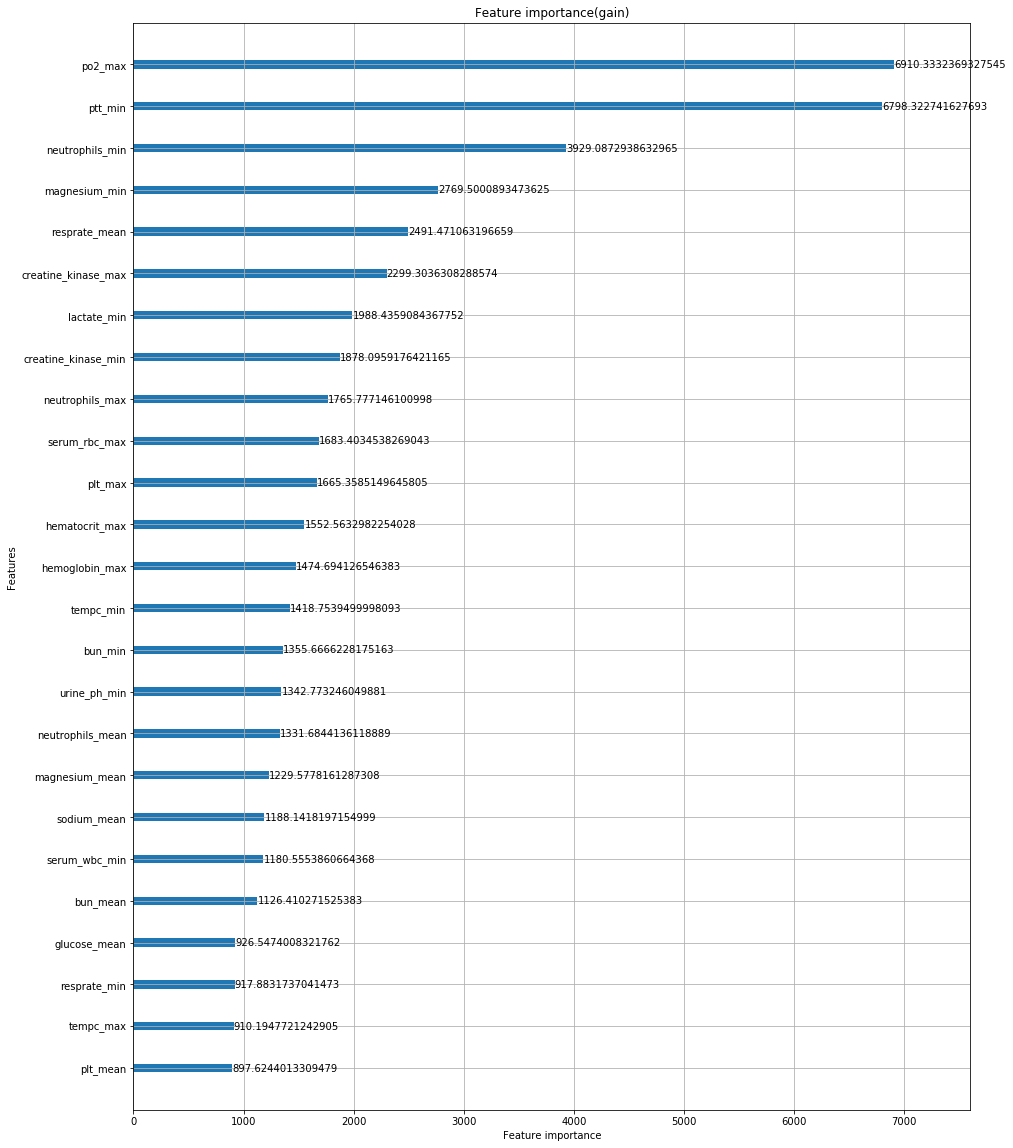

In [28]:
plt.figure()
ax = lgb.plot_importance(gbm,max_num_features=25,figsize=(15,20),title='Feature importance(gain)',importance_type='gain')
# plt.gcf().savefig('feature_importance_gain.png')
plt.show()

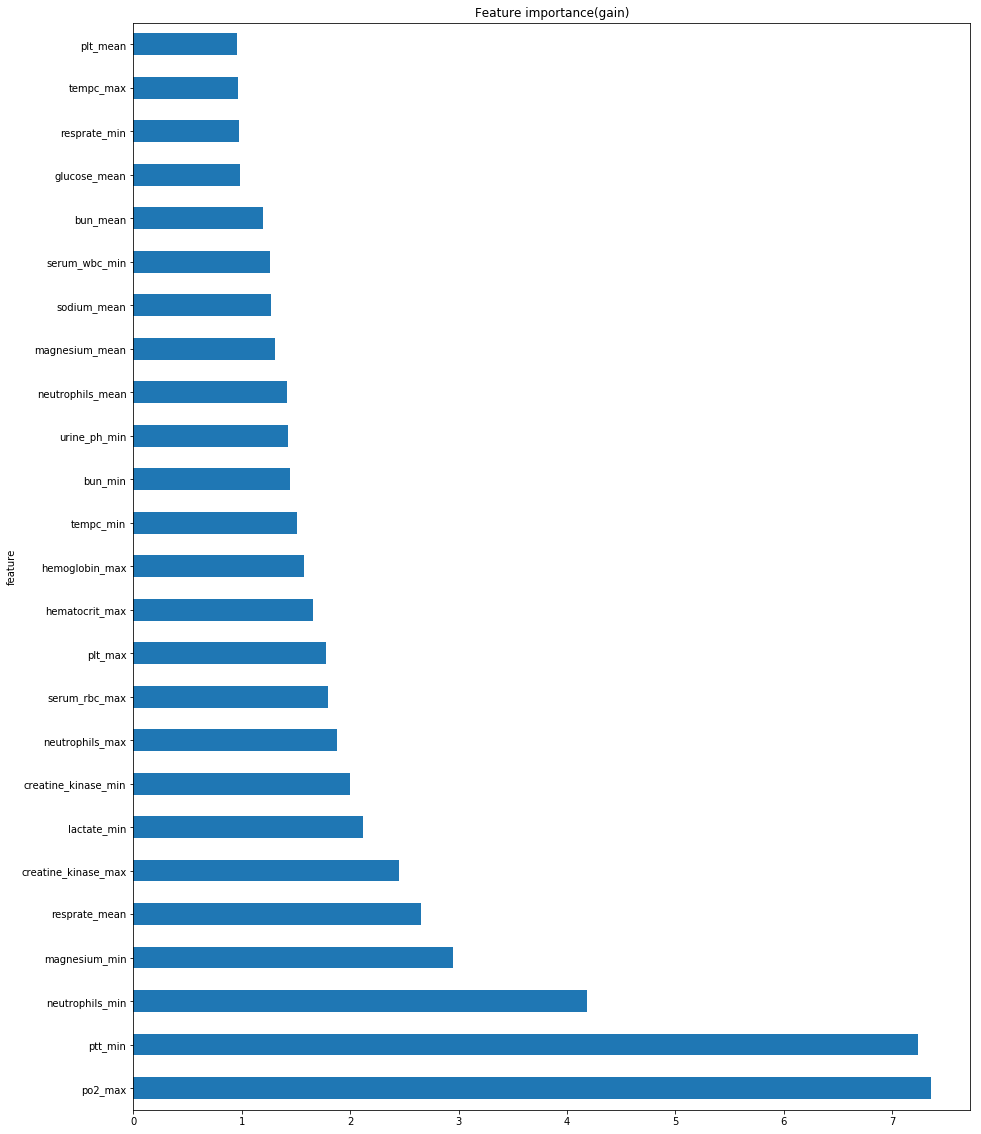

In [29]:
plt.figure()
feat_imp[['feature','gain']].head(25).plot(kind='barh', x='feature', y='gain', legend=False, figsize=(15, 20),title='Feature importance(gain)')
plt.gcf().savefig('features_importance_gain.png')
plt.show()